In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
from torch.utils.data import DataLoader, random_split
from google.colab import drive
from PIL import Image

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

✅ Using device: cpu


In [ ]:
# Dataset paths
train_dir = "/content/drive/MyDrive/train"
test_dir = "/content/drive/MyDrive/test"

In [ ]:
# Image transformations for training (with augmentation)
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=0, shear=0.2, scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Image transformations for test/validation (without augmentation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Load datasets
full_train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

In [ ]:
# Split training set into training and validation sets
train_size = int(0.8 * len(full_train_dataset))  # 80% for training
val_size = len(full_train_dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

In [ ]:
# Data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

class_names = full_train_dataset.classes
print(f"✅ Classes: {class_names}")



✅ Classes: ['n01675722', 'n01729322', 'n01756291', 'n01986214', 'n02011460']


In [ ]:
# Load GoogLeNet
googlenet = models.googlenet(pretrained=True)
googlenet_feature_extractor = nn.Sequential(*list(googlenet.children())[:-3])
googlenet_feature_extractor.to(device)
googlenet_feature_extractor.eval()

Sequential(
  (0): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (5): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (bra

In [ ]:
# Feature extraction function
def extract_features(model, dataloader, filename):
    if os.path.exists(filename):
        print(f"Loading cached features from {filename}...")
        with open(filename, "rb") as f:
            return pickle.load(f)

    print("Extracting features...")
    features, labels = [], []
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            output = model(images)
            output = torch.mean(output, dim=[2, 3])  # Global Average Pooling
            features.append(output.cpu())
            labels.append(targets.cpu())
    features, labels = torch.cat(features), torch.cat(labels)
    with open(filename, "wb") as f:
        pickle.dump((features, labels), f)
    return features, labels

train_features, train_labels = extract_features(googlenet_feature_extractor, train_loader, "google_train.pkl")
val_features, val_labels = extract_features(googlenet_feature_extractor, val_loader, "google_val.pkl")
test_features, test_labels = extract_features(googlenet_feature_extractor, test_loader, "google_test.pkl")

⚡ Loading cached features from google_train.pkl...
⚡ Loading cached features from google_val.pkl...
⚡ Loading cached features from google_test.pkl...


In [ ]:
# Define MLFFNN
class MLFFNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLFFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 100)
        self.bn1 = nn.BatchNorm1d(100)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(100, 50)
        self.bn2 = nn.BatchNorm1d(50)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(50, num_classes)

    def forward(self, x):
        x = self.relu1(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = self.relu2(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

print("✅ MLFFNN Defined with BatchNorm & Dropout!")
mlffnn = MLFFNN(train_features.shape[1], len(class_names)).to(device)


✅ MLFFNN Defined with BatchNorm & Dropout!


In [ ]:
# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlffnn.parameters(), lr=0.0005)

def train_model(model, train_features, train_labels, val_features, val_labels, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(train_features)
        loss = criterion(outputs, train_labels)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_outputs = model(val_features)
            val_loss = criterion(val_outputs, val_labels)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")
    print("✅ Training Completed!")

train_model(mlffnn, train_features, train_labels, val_features, val_labels, optimizer)


Epoch [1/10], Loss: 1.6362, Val Loss: 1.5855
Epoch [2/10], Loss: 1.5244, Val Loss: 1.5565
Epoch [3/10], Loss: 1.4299, Val Loss: 1.5242
Epoch [4/10], Loss: 1.3619, Val Loss: 1.4885
Epoch [5/10], Loss: 1.3062, Val Loss: 1.4500
Epoch [6/10], Loss: 1.2635, Val Loss: 1.4100
Epoch [7/10], Loss: 1.2187, Val Loss: 1.3691
Epoch [8/10], Loss: 1.1983, Val Loss: 1.3282
Epoch [9/10], Loss: 1.1657, Val Loss: 1.2887
Epoch [10/10], Loss: 1.1446, Val Loss: 1.2508
✅ Training Completed!


In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            features = googlenet_feature_extractor(images)
            features = torch.mean(features, dim=[2, 3])
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"✅ Test Accuracy: {accuracy:.2f}%")
    return accuracy

evaluate_model(mlffnn, test_loader)

✅ Test Accuracy: 75.14%


75.14285714285714

In [ ]:
def load_test_images(folder_path, num_images=5):
    """Loads test images from a folder and applies transformations."""
    images, filenames = [], []
    image_filenames = os.listdir(folder_path)[:num_images]

    for filename in image_filenames:
        img_path = os.path.join(folder_path, filename)
        img = Image.open(img_path).convert("RGB")  # Convert to RGB if grayscale
        img = test_transform(img)
        images.append(img)
        filenames.append(filename)

    return images, filenames

✅ GoogLeNet + MLFFNN Predictions:


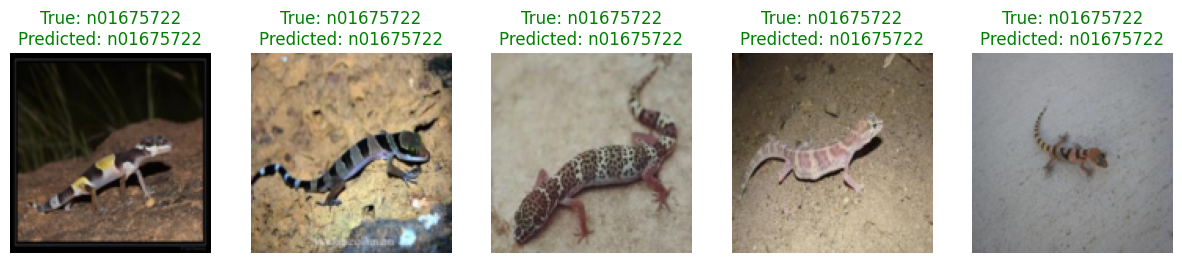

In [ ]:
def predict_images(model, feature_extractor, folder_path, class_names, num_images=5, true_class=None):
    """Predicts and displays images with the predicted and true class."""
    model.eval()
    images, filenames = load_test_images(folder_path, num_images)

    images_tensor = torch.stack(images).to(device)  # Convert list to tensor

    with torch.no_grad():
        features = feature_extractor(images_tensor)
        features = torch.mean(features, dim=[2, 3])  # Global Average Pooling (GAP)
        outputs = model(features)
        predicted_classes = torch.argmax(outputs, dim=1)  # Get predicted class index

    # Display results
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, ax in enumerate(axes):
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
        img = np.clip(img, 0, 1)

        predicted_label = class_names[predicted_classes[i]]
        true_label = true_class if true_class else "Unknown"

        ax.imshow(img)
        ax.set_title(f"True: {true_label}\nPredicted: {predicted_label}", fontsize=12, color="green")
        ax.axis("off")

    plt.show()

# Example usage
test_folder = "/content/drive/MyDrive/test/n01675722"  # Change as needed
true_class_name = "n01675722"  # Replace with actual class name if known

print("✅ GoogLeNet + MLFFNN Predictions:")
predict_images(mlffnn, googlenet_feature_extractor, test_folder, class_names, num_images=5, true_class=true_class_name)


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch


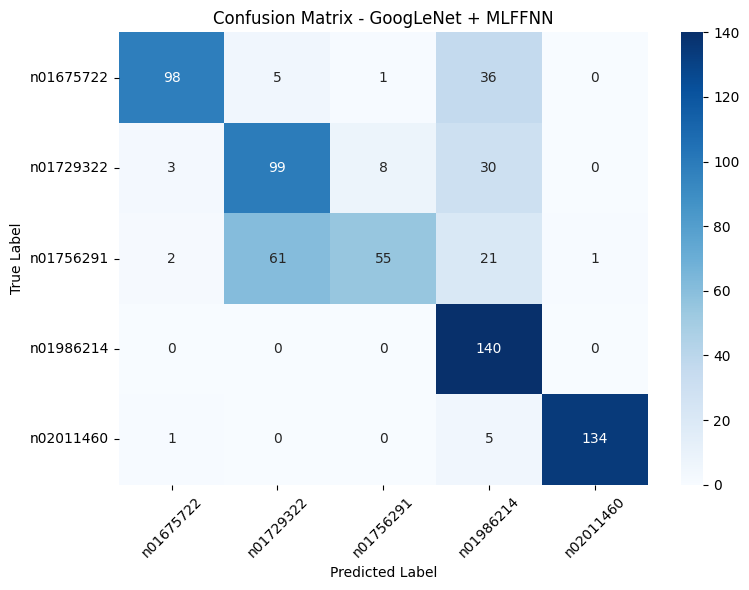

In [ ]:
# Step 1: Generate predictions and collect true labels
all_preds = []
all_labels = []

mlffnn.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        features = googlenet_feature_extractor(images)
        features = torch.mean(features, dim=[2, 3])
        outputs = mlffnn(features)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Step 2: Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = test_dataset.classes  # Same class list used in training

# Step 3: Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - GoogLeNet + MLFFNN')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


✅ Test Accuracy: 75.14%
📊 Classification Report:

              precision    recall  f1-score   support

   n01675722       0.94      0.70      0.80       140
   n01729322       0.60      0.71      0.65       140
   n01756291       0.86      0.39      0.54       140
   n01986214       0.60      1.00      0.75       140
   n02011460       0.99      0.96      0.97       140

    accuracy                           0.75       700
   macro avg       0.80      0.75      0.74       700
weighted avg       0.80      0.75      0.74       700


📄 LaTeX file for report saved as classification_report.tex


<ipython-input-26-ce0de954fc0e>:44: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


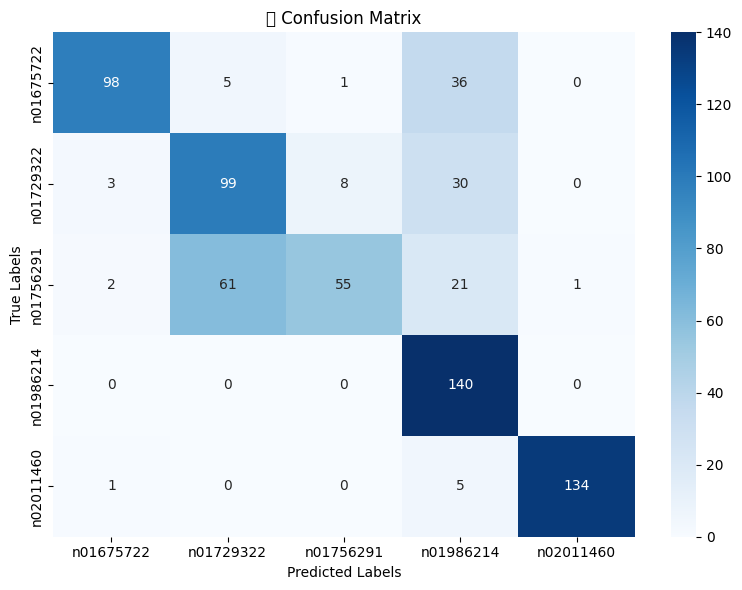

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch

# Step 1: Get predictions on the test set
mlffnn.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        features = googlenet_feature_extractor(images)
        features = torch.mean(features, dim=[2, 3])  # GAP
        outputs = mlffnn(features)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Step 2: Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"✅ Test Accuracy: {accuracy * 100:.2f}%")

# Step 3: Classification report
report = classification_report(all_labels, all_preds, target_names=class_names)
print("📊 Classification Report:\n")
print(report)

# Optional: Convert to pandas and save as LaTeX
report_df = pd.DataFrame(classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)).transpose()
report_df.to_latex("classification_report.tex")  # Optional if you want LaTeX table
print("\n📄 LaTeX file for report saved as classification_report.tex")

# Step 4: Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("📌 Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()
